In [1]:
%matplotlib inline
import axs
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pandas as pd

from multiprocessing import Pool

import h5py
import pyspark.sql.functions as sparkfunc

In [2]:
from pyspark.sql import SparkSession
spark_session = (SparkSession.builder
         .config('spark.master', "local[10]") # 20 when running the full crossmatch, 10 when doing validation.
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         .config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/jupyter/user/ecbellm/proxy/4040")
         .config("spark.port.maxRetries", "128")
         .enableHiveSupport()
         .getOrCreate())
spark_session

In [3]:
catalog = axs.AxsCatalog(spark_session)

In [4]:
catalog.list_tables().keys()

dict_keys(['gaia_dr2_1am_dup', 'allwise_1am_dup', 'unwise_v1', 'cklein_flare', 'unwise_v2', 'catalina_variables_n', 'gaia', 'gaia_dr2_1am_dup_ssd', 'ps1', 'green19_stellar_params', 'rosat_2rxs', 'rosat_2rxs_z4am_b2am', 'ztf_dr3_2rxs_obj', 'wtf_ztf_dr3', 'ztf_wds_kjb_dr3', 'karenws_cut_wtf_fits_r_band', 'karenws_cut_wtf_fits', 'ztf_aug2020_2rxs_obj', 'skymapper_dr2', 'test_skymapper', 'skymapper_dr2_ver2', 'skymapper_dr2_ver3', 'ztf_rrlyr', 'gaia_source_edr3', 'gaia_edr3_distances', 'rrlyrae_sample_andy', 'stevengs_test_small_df', 'ztf5', 'feh_rrlyr_ab_020620', 'kepler_rrlyrae', 'ztf_kepler_rrlyrae', 'ps_uband', 'ps_uband_ver2', 'debug_match_a', 'debug_match_b', 'debug_match_c', 'ztf_rrlyr_grid_50', 'igaps_halpha_emitters', 'wtf_aug2020_asymmetric_2', 'wtf_aug2020_asymmetric_3', 'wtf_aug2020_dip_candidates', 'ztf_rr_lyrae_preprocessed_and_gridded_09_01_2021', 'ztf_rr_lyrae_phi_31_fits_09_01_2021', 'stevengs_test_sources', 'ddf_sources_bigger', 'ztf_dr7', 'jrad_zg98m', 'jrad_zgd98m', 'jr

## GaiaSource

In [16]:
df_test = spark_session.read.csv('/epyc/data/gaia_dr3/csv/GaiaSource/GaiaSource_000000-003111.csv.gz',comment='#',header=True,inferSchema=True)

In [17]:
df_test.schema

StructType(List(StructField(solution_id,LongType,true),StructField(designation,StringType,true),StructField(source_id,LongType,true),StructField(random_index,IntegerType,true),StructField(ref_epoch,DoubleType,true),StructField(ra,DoubleType,true),StructField(ra_error,DoubleType,true),StructField(dec,DoubleType,true),StructField(dec_error,DoubleType,true),StructField(parallax,DoubleType,true),StructField(parallax_error,DoubleType,true),StructField(parallax_over_error,DoubleType,true),StructField(pm,DoubleType,true),StructField(pmra,DoubleType,true),StructField(pmra_error,DoubleType,true),StructField(pmdec,DoubleType,true),StructField(pmdec_error,DoubleType,true),StructField(ra_dec_corr,DoubleType,true),StructField(ra_parallax_corr,DoubleType,true),StructField(ra_pmra_corr,DoubleType,true),StructField(ra_pmdec_corr,DoubleType,true),StructField(dec_parallax_corr,DoubleType,true),StructField(dec_pmra_corr,DoubleType,true),StructField(dec_pmdec_corr,DoubleType,true),StructField(parallax_pmr

In [18]:
df_test.head()

Row(solution_id=1636148068921376768, designation='Gaia DR3 4295806720', source_id=4295806720, random_index=545300884, ref_epoch=2016.0, ra=44.99615537864534, ra_error=0.10161827, dec=0.005615226341865997, dec_error=0.10133387, parallax=0.3543305595550248, parallax_error=0.12266381, parallax_over_error=2.8886316, pm=12.616485, pmra=11.93835156938502, pmra_error=0.13794228, pmdec=-4.0806193394130865, pmdec_error=0.13316983, ra_dec_corr=0.12293493, ra_parallax_corr=0.13202813, ra_pmra_corr=-0.08891027, ra_pmdec_corr=0.022551458, dec_parallax_corr=-0.3653421, dec_pmra_corr=-0.03690377, dec_pmdec_corr=-0.24483804, parallax_pmra_corr=0.06301233, parallax_pmdec_corr=0.13570854, pmra_pmdec_corr=0.3343367, astrometric_n_obs_al=184, astrometric_n_obs_ac=0, astrometric_n_good_obs_al=183, astrometric_n_bad_obs_al=1, astrometric_gof_al=2.6720488, astrometric_chi2_al=242.20697, astrometric_excess_noise=0.3806193, astrometric_excess_noise_sig=2.0765078, astrometric_params_solved=31, astrometric_prima

In [19]:
df_test.count()

528333

In [20]:
df = spark_session.read.csv('/epyc/data/gaia_dr3/csv/GaiaSource',comment='#',header=True,schema=df_test.schema)

In [ ]:
# save source_id, ra, dec 

In [21]:
df.select('source_id','ra','dec').write.parquet('/epyc/data/gaia_dr3/source_id_ra_dec.parquet')

In [69]:
df.count()

1811709771

In [ ]:
%%time

catalog.save_axs_table(df, "gaia_dr3_source", calculate_zone=True)

## test Gaia Source

In [5]:
gaia = catalog.load("gaia_dr3_source")

In [6]:
gaia.columns

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_sigma5d_max

In [7]:
def histogram2d(axsframe, cond1, cond2, numbins1, numbins2, min1=None, max1=None, min2=None, max2=None):
    """
    Uses `cond1` and `cond2` colunm expressions to obtain data for 2D histogram calculation. The data on
    x axis will be binned into `numbins1` bins. The data on y axis will be binned into `numbins2` bins.
    If `min1`, `max1`, `min2` or `max2` are not spacified, they will be calculated using an additional pass
    through the data.
    The method returns x, y and z 2-D numpy arrays (see numpy.mgrid) which can be used as an input to
    `matplotlib.pcolormesh`.
    :param cond1: Column expression determining the data on x axis.
    :param cond2: Column expression determining the data on y axis.
    :param numbins1: Number of bins for x axis.
    :param numbins2: Number of bins for y axis.
    :param min1: Optional minimum value for x axis data.
    :param max1: Optional maximum value for x axis data.
    :param min2: Optional minimum value for y axis data.
    :param max2: Optional maximum value for y axis data.
    :return: x, y, z 2-D numpy "meshgrid" arrays (see numpy.mgrid)
    """
    colname1 = "axs_hist_col1"
    colname2 = "axs_hist_col2"
    res = axsframe._df.select(cond1.alias(colname1), cond2.alias(colname2))

    if min1 is None or max1 is None or min2 is None or max2 is None:
        mm = res.select(F.min(res[colname1]).alias("min1"), F.max(res[colname1]).alias("max1"),
                        F.min(res[colname2]).alias("min2"), F.max(res[colname2]).alias("max2")).\
            collect()
        (min1, max1, min2, max2) = (mm[0]["min1"], mm[0]["max1"], mm[0]["min2"], mm[0]["max2"])

    range1 = float(max1 - min1)
    range2 = float(max2 - min2)
    step1 = range1 / numbins1
    step2 = range2 / numbins2

    hist2d = res.withColumn("bin1", ((res[colname1]-min1)/step1).cast("int")) \
        .withColumn("bin2", ((res[colname2]-min2)/step2).cast("int")).\
        groupBy("bin1", "bin2").count().toPandas()

    bin1 = np.array(hist2d['bin1'], dtype='int')
    bin2 = np.array(hist2d['bin2'], dtype='int')
    vals = np.array(hist2d['count'], dtype='int')

    x, y = np.mgrid[slice(min1, max1 + step1, step1),
                    slice(min2, max2 + step2, step2)]

    z = np.zeros(numbins1*numbins2)
    ok_bins, = np.where((bin1 >= 0) & (bin1 < numbins1) & (bin2 >= 0) & (bin2 < numbins2))
    bin_onedim_index = bin2 + bin1*numbins2
    z[bin_onedim_index[ok_bins]] = vals[ok_bins]
    
    return x, y, z.reshape((numbins1, numbins2))

In [8]:
%%time
x,y,hist = histogram2d(gaia, gaia['ra'], gaia['dec'], 360*10, 90*10, min1=0, max1=360, min2=-90, max2=90)

CPU times: user 224 ms, sys: 119 ms, total: 343 ms
Wall time: 4min 15s


In [10]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

Text(0, 0.5, 'Dec')

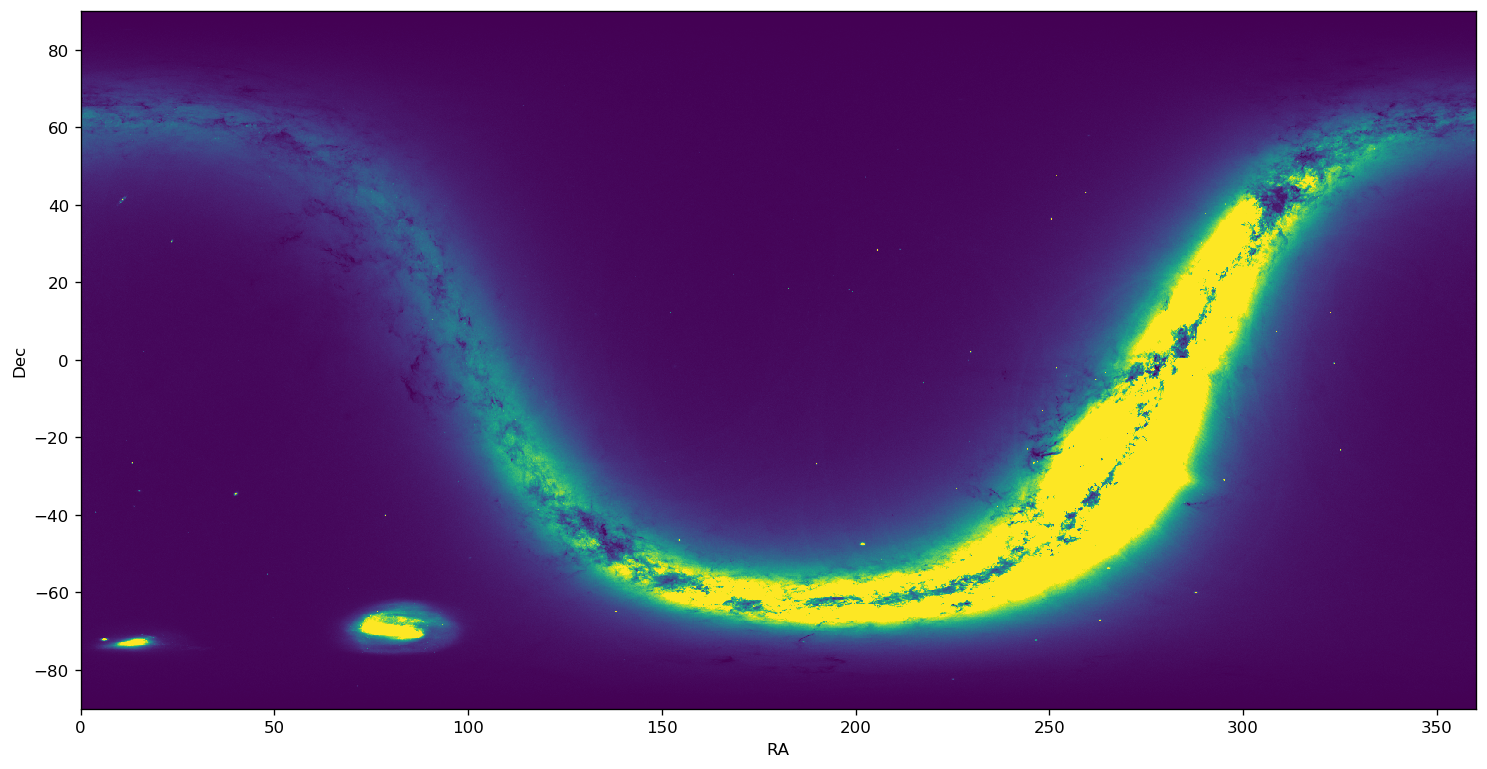

In [14]:
plt.figure(figsize=(15,10))
extent = (0, 360, -90, 90)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.1*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

